In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose

## 0: Data preparation

Note: the first row, empty columns and text boxes were **deleted before proccessing in python**

In [3]:
data = pd.read_excel("PG DS - Middle Econometrist Test task.xlsx", sheet_name="data")
print(data.columns)
data.describe()

Index(['Date', 'Year', 'Week', 'MS_value_%', 'MS_volume_%',
       'Weighted_distribution', 'Volume sales, pcs', 'Value sales, UAH',
       'Video, TRP', 'SMM, TRP', 'TV, TRP'],
      dtype='object')


,Year,Week,MS_value_%,MS_volume_%,Weighted_distribution,"Volume sales, pcs","Value sales, UAH","Video, TRP","SMM, TRP","TV, TRP"
count,167.000000,167.000000,167.000000,167.000000,167.000000,1.670000e+02,1.670000e+02,167.000000,167.000000,167.000000
mean,2021.131737,25.149701,0.177262,0.075579,89.461317,4.150532e+05,3.562811e+07,5.236311,13.134937,102.835310
std,0.934937,15.438814,0.019472,0.011475,6.208531,2.519513e+05,2.164018e+07,6.947833,11.686159,108.845697
min,2020.000000,1.000000,0.135683,0.051484,69.410000,6.695836e+04,4.749757e+06,0.000000,0.000000,0.000000
25%,2020.000000,11.000000,0.166401,0.067730,85.750000,2.079299e+05,1.652133e+07,0.000000,0.000000,0.000000
50%,2021.000000,25.000000,0.175959,0.074738,92.270000,3.787262e+05,3.659004e+07,0.000000,14.677845,0.000000
75%,2022.000000,38.500000,0.185486,0.081772,94.020000,5.814479e+05,4.833492e+07,9.736477,20.624273,209.840000
max,2023.000000,52.000000,0.242038,0.107712,95.260000,1.118501e+06,1.047959e+08,32.284152,47.860061,311.550000


In [4]:
try:
    data["Date"] = data["Date"].str.replace(" ", "-")
    data["Date"] = pd.to_datetime(data["Date"] + "-1", format="%Y-W%W-%w")
except Exception as e:
    pass
print(data.info())
data.head(3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 167 entries, 0 to 166
Data columns (total 11 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   Date                   167 non-null    datetime64[ns]
 1   Year                   167 non-null    int64         
 2   Week                   167 non-null    int64         
 3   MS_value_%             167 non-null    float64       
 4   MS_volume_%            167 non-null    float64       
 5   Weighted_distribution  167 non-null    float64       
 6   Volume sales, pcs      167 non-null    float64       
 7   Value sales, UAH       167 non-null    float64       
 8   Video, TRP             167 non-null    float64       
 9   SMM, TRP               167 non-null    float64       
 10  TV, TRP                167 non-null    float64       
dtypes: datetime64[ns](1), float64(8), int64(2)
memory usage: 14.5 KB
None


,Date,Year,Week,MS_value_%,MS_volume_%,Weighted_distribution,"Volume sales, pcs","Value sales, UAH","Video, TRP","SMM, TRP","TV, TRP"
0,2020-01-06,2020,1,0.194662,0.073238,92.99,684745.27,46790938.18,0.000000,0.0,206.18
1,2020-01-13,2020,2,0.194925,0.071813,92.99,621840.71,41667580.50,0.000000,0.0,222.20
2,2020-01-20,2020,3,0.186264,0.067827,92.99,671657.94,44403164.56,9.548402,0.0,201.56


## 1. Analyze brand's volume & value MS% dynamics, estimate brand's seasonality

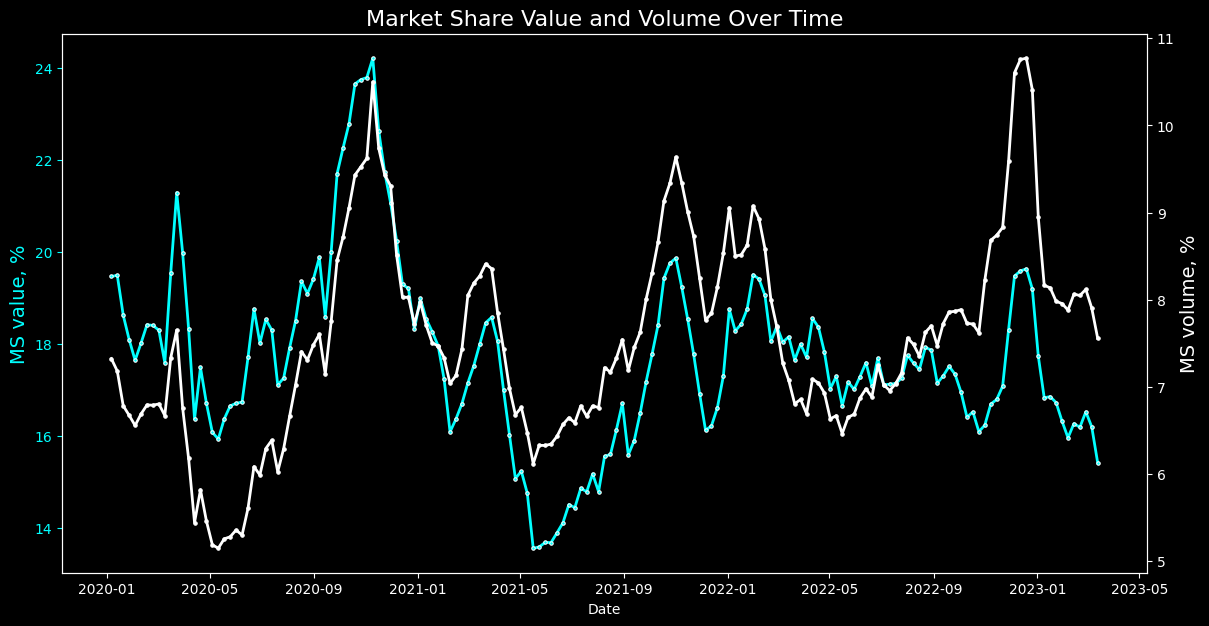

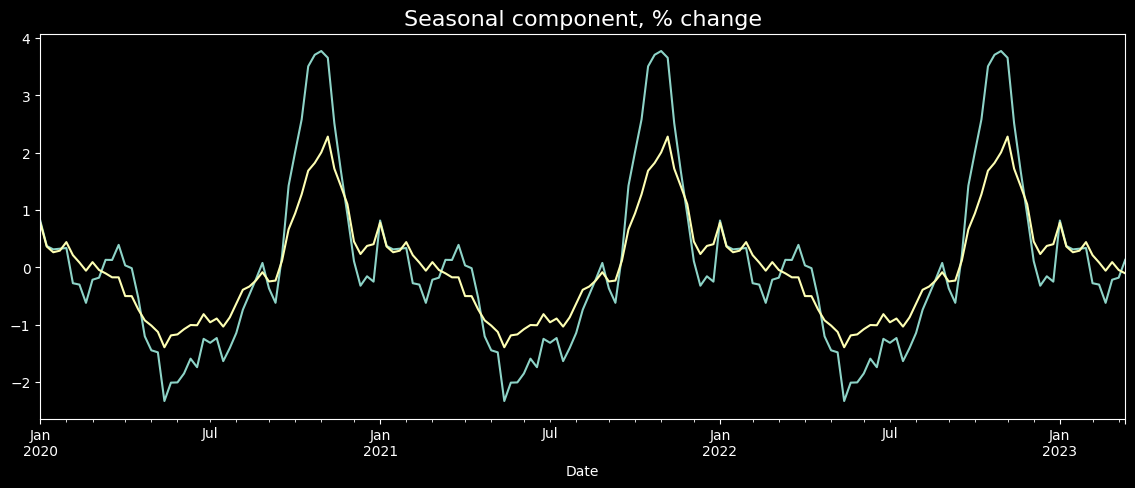

In [5]:
temp = data.copy()
temp["MS_value_%"], temp["MS_volume_%"] = temp["MS_value_%"] * 100, temp["MS_volume_%"] * 100

plt.style.use('dark_background')

fig, ax = plt.subplots(figsize=(14, 7))
ax2 = ax.twinx()
sns.lineplot(data=temp, x="Date", y="MS_value_%", marker="o", ax=ax, color="cyan", markersize=2.5, linewidth=2)
sns.lineplot(data=temp, x="Date", y="MS_volume_%", marker="o", ax=ax2, color="white", markersize=2.5, linewidth=2)
ax.set_ylabel("MS value, %", color="cyan", fontsize=14)
ax.tick_params(axis='y', colors='cyan')
ax2.set_ylabel("MS volume, %", color="white", fontsize=14)
plt.title("Market Share Value and Volume Over Time", fontsize=16)
# sns.despine(left=True, right=True)
plt.show()

decomposition_value = seasonal_decompose(temp.set_index("Date")["MS_value_%"], model='additive', period=52)
decomposition_volume = seasonal_decompose(temp.set_index("Date")["MS_volume_%"], model='additive', period=52)
decomposition_value.seasonal.plot(figsize=(14, 5), title="Seasonal Component of MS_value_%")
decomposition_volume.seasonal.plot(figsize=(14, 5), title="Seasonal Component of MS_volume_%")
plt.title("Seasonal component, % change", fontsize=16)
plt.show()


## 2. Calculate average brand price, price index (brand's price relatively to market price).

In [6]:
data["brand_volume"] = data["Volume sales, pcs"] * data["MS_volume_%"]
data["brand_value"] = data["Value sales, UAH"] * data["MS_value_%"]

data["avg_brand_price"] = data["brand_value"] / data["brand_volume"]
data["market_avg_price"] = data["Value sales, UAH"] / data["Volume sales, pcs"]

data["price_index"] = data["avg_brand_price"] / data["market_avg_price"]

pd.DataFrame(data.agg({"avg_brand_price": "mean",
                       "market_avg_price": "mean",
                       "price_index": "mean"}), columns=["Value"]).T.rename(columns={"avg_brand_price": "Average Brand Price",
                                                                           "market_avg_price": "Average Market Price",
                                                                           "price_index": "Average Price Index"})


,Average Brand Price,Average Market Price,Average Price Index
Value,201.556362,86.496892,2.378572


### 3. Assuming all available variables are exogenous, build a regression model to estimate influence of price, weighted distribution & media support on volume MS%. Include seasonality, if relevant. Please justify the chosen regression method. 

                            OLS Regression Results                            
Dep. Variable:            MS_volume_%   R-squared:                       0.806
Model:                            OLS   Adj. R-squared:                  0.707
Method:                 Least Squares   F-statistic:                     15.75
Date:                Sat, 22 Nov 2025   Prob (F-statistic):           4.55e-33
Time:                        14:08:57   Log-Likelihood:                 215.59
No. Observations:                 167   AIC:                            -317.2
Df Residuals:                     110   BIC:                            -139.4
Df Model:                          56                                         
Covariance Type:                  HAC                                         
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                 

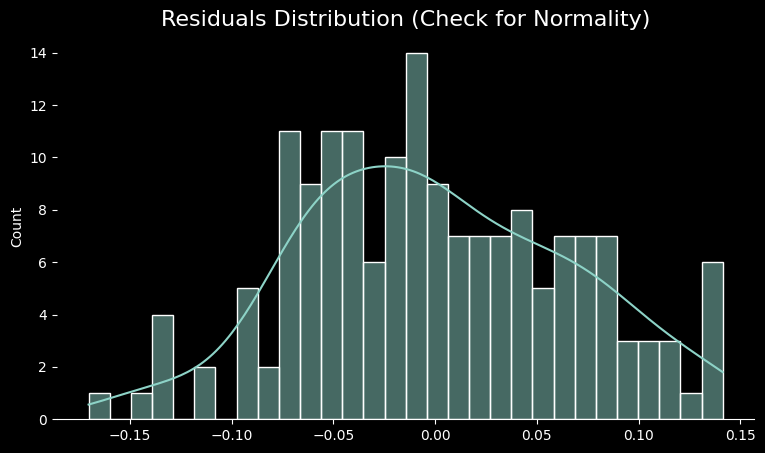

In [ ]:
# data["media_support, TRP"] = data[["Video, TRP", "SMM, TRP", "TV, TRP"]].sum(axis=1)
week_dummies = pd.get_dummies(data["Week"], prefix="week", drop_first=True).astype(int)
for col in ["price_index", "Weighted_distribution", "Video, TRP", "SMM, TRP", "TV, TRP"]:
    log_name = "log_" + col
    data[log_name] = np.log(data[col] + 1e-6)
y = np.log(data["MS_volume_%"])
X = data[["log_price_index", "log_Weighted_distribution", "log_Video, TRP", "log_SMM, TRP", "log_TV, TRP"]].copy()

X1 = sm.add_constant(X)
model1 = sm.OLS(y, X1).fit(cov_type="HAC", cov_kwds={"maxlags": 8})

X2 = sm.add_constant(pd.concat([X, week_dummies], axis=1))
model2 = sm.OLS(y, X2).fit(cov_type='HAC', cov_kwds={"maxlags": 8})

best = model1 if model1.rsquared_adj > model2.rsquared_adj else model2
print(best.summary())

from statsmodels.stats.outliers_influence import variance_inflation_factor
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]  
print(vif_data)

from statsmodels.stats.stattools import durbin_watson
dw_stat = durbin_watson(best.resid)
print(f'\nDurbin-Watson statistic: {dw_stat}\n')

from statsmodels.stats.diagnostic import linear_rainbow
test_statistic, p_value = linear_rainbow(best)
print(f"Rainbow Test p-value: {p_value}\n")

import statsmodels.stats.api as sms
name = ['Lagrange multiplier statistic', 'p-value', 'f-value', 'f p-value']
test = sms.het_breuschpagan(best.resid, best.model.exog)
print(dict(zip(name, test)))

plt.figure(figsize=(9, 5))
sns.histplot(best.resid, bins=30, kde=True)
plt.title("Residuals Distribution (Check for Normality)", fontsize=16)
sns.despine(left=True, right=True)
plt.show()


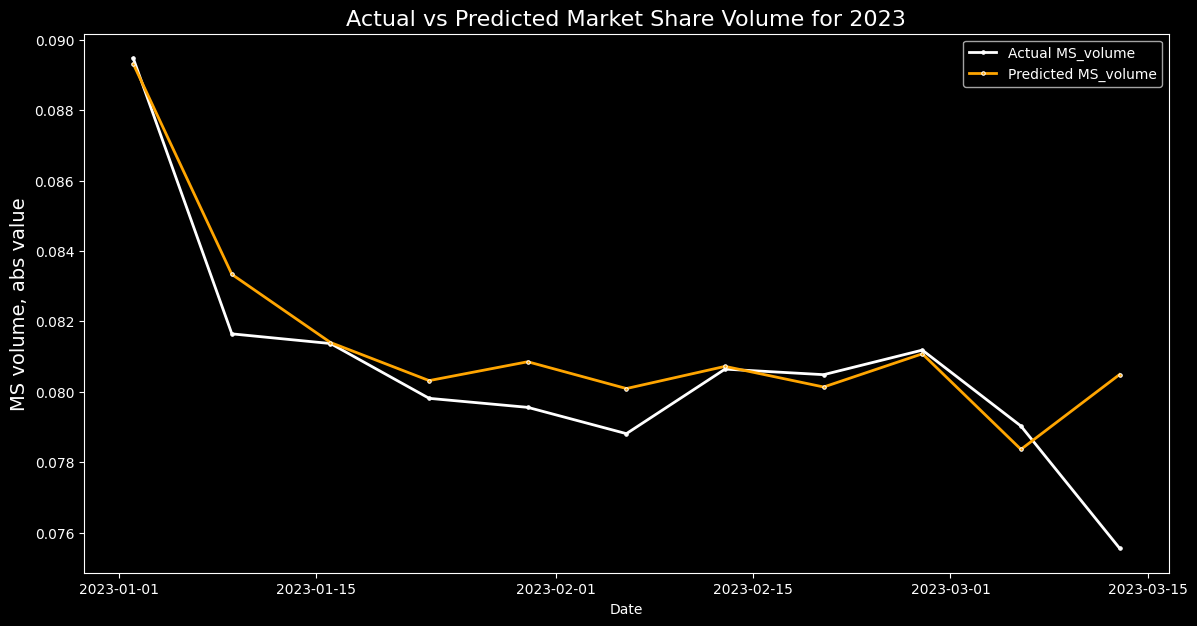

RMSE for 2023 predictions, in %: 0.1689%


In [20]:
df_2023 = data[data["Year"] == 2023].copy()
# df_2023["media_support, TRP"] = df_2023[["Video, TRP", "SMM, TRP", "TV, TRP"]].sum(axis=1)
for col in ["price_index", "Weighted_distribution", "Video, TRP", "SMM, TRP", "TV, TRP"]:
    log_name = "log_" + col
    df_2023[log_name] = np.log(df_2023[col] + 1e-6)
week_dummies_2023 = pd.get_dummies(df_2023["Week"], prefix="week", drop_first=True).astype(int)
for col in week_dummies.columns:
    if col not in week_dummies_2023:
        week_dummies_2023[col] = 0
week_dummies_2023 = week_dummies_2023[week_dummies.columns]  # same order
X_2023 = df_2023[["log_price_index", "log_Weighted_distribution", "log_Video, TRP", "log_SMM, TRP", "log_TV, TRP"]].copy()
X_2023 = sm.add_constant(pd.concat([X_2023, week_dummies_2023], axis=1))

df_2023["predicted_log_MS_volume_%"] = best.predict(X_2023)
df_2023["predicted_MS_volume_%"] = np.exp(df_2023["predicted_log_MS_volume_%"])
df_2023[["Date", "MS_volume_%", "predicted_MS_volume_%"]]

# plot actual vs predicted
fig, ax = plt.subplots(figsize=(14, 7))
sns.lineplot(data=df_2023, x="Date", y="MS_volume_%", marker="o", ax=ax, color="white", markersize=2.5, linewidth=2, label="Actual MS_volume")
sns.lineplot(data=df_2023, x="Date", y="predicted_MS_volume_%", marker="o", ax=ax, color="orange", markersize=2.5, linewidth=2, label="Predicted MS_volume")
ax.set_ylabel("MS volume, abs value", color="white", fontsize=14)
ax.tick_params(axis='y', colors='white')
plt.title("Actual vs Predicted Market Share Volume for 2023", fontsize=16)
plt.legend()
plt.show()

# rmse
rmse = np.sqrt(np.mean((df_2023["MS_volume_%"] - df_2023["predicted_MS_volume_%"]) ** 2))
print(f'RMSE for 2023 predictions, in %: {rmse*100:.4f}%')

In [26]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller

df = data.copy()
endog = np.log(df["MS_volume_%"])
adf_result = adfuller(endog)
print(f'p-value: {adf_result[1]}, Stationarity: {"Yes" if adf_result[1] < 0.05 else "No"}')
exog = df[["price_index", "Weighted_distribution", "Video, TRP", "SMM, TRP", "TV, TRP"]]
model_sarima = SARIMAX(endog, exog=exog, order=(1,0,0), seasonal_order=(1,1,0,52))
results_sarima = model_sarima.fit(disp=False)
print(results_sarima.summary())

p-value: 0.036226633571398895, Stationarity: Yes


c:\Users\38095\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                                     SARIMAX Results                                      
Dep. Variable:                        MS_volume_%   No. Observations:                  167
Model:             SARIMAX(1, 0, 0)x(1, 1, 0, 52)   Log Likelihood                 185.198
Date:                            Sat, 22 Nov 2025   AIC                           -354.395
Time:                                    14:19:59   BIC                           -332.436
Sample:                                         0   HQIC                          -345.482
                                            - 167                                         
Covariance Type:                              opg                                         
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
price_index              -0.2615      0.055     -4.792      0.000      -0.368      -0.155
We

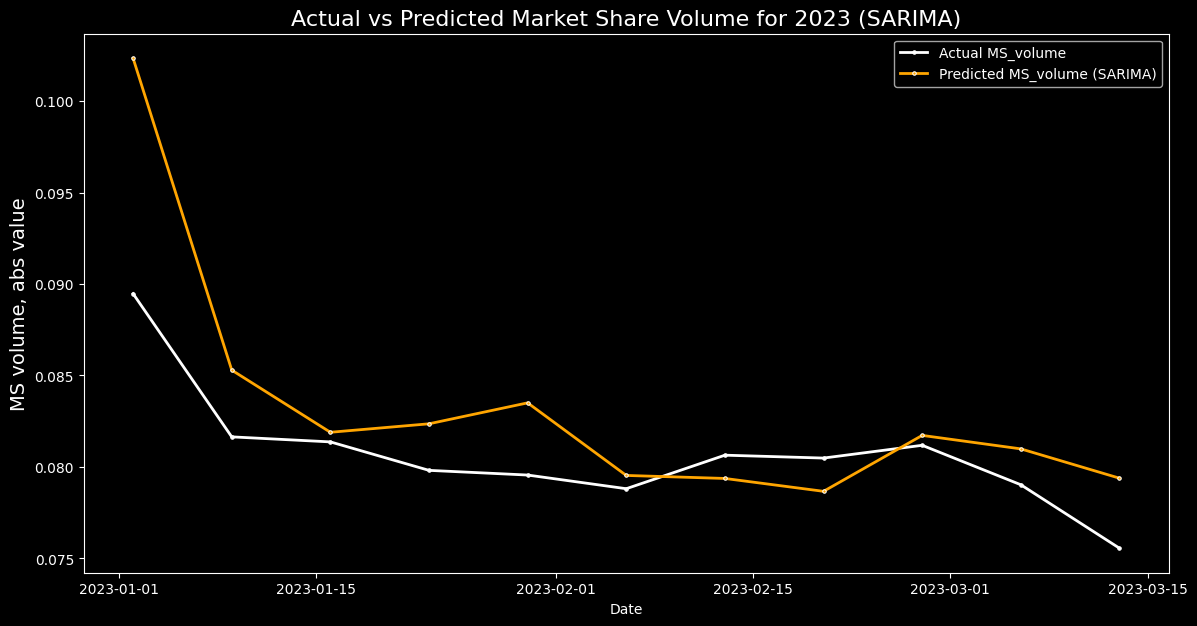

RMSE for 2023 predictions using SARIMA, in %: 0.4529%


In [27]:
df_2023_arima = data[data["Year"] == 2023].copy()
exog_2023 = df_2023_arima[["price_index", "Weighted_distribution", "Video, TRP", "SMM, TRP", "TV, TRP"]].copy()
start_idx = df_2023_arima.index[0]
end_idx = df_2023_arima.index[-1]

df_2023_arima["predicted_log_MS_volume_%"] = results_sarima.predict(start=start_idx, end=end_idx, exog=exog_2023)
df_2023_arima["predicted_MS_volume_%"] = np.exp(df_2023_arima["predicted_log_MS_volume_%"])
df_2023_arima[["Date", "MS_volume_%", "predicted_MS_volume_%"]]

# plot actual vs predicted for SARIMA
fig, ax = plt.subplots(figsize=(14, 7))
sns.lineplot(data=df_2023_arima, x="Date", y="MS_volume_%", marker="o", ax=ax, color="white", markersize=2.5, linewidth=2, label="Actual MS_volume")
sns.lineplot(data=df_2023_arima, x="Date", y="predicted_MS_volume_%", marker="o", ax=ax, color="orange", markersize=2.5, linewidth=2, label="Predicted MS_volume (SARIMA)")
ax.set_ylabel("MS volume, abs value", color="white", fontsize=14)
ax.tick_params(axis='y', colors='white')
plt.title("Actual vs Predicted Market Share Volume for 2023 (SARIMA)", fontsize=16)
plt.legend()
plt.show()

# rmse for SARIMA
rmse_sarima = np.sqrt(np.mean((df_2023_arima["MS_volume_%"] - df_2023_arima["predicted_MS_volume_%"]) ** 2))
print(f'RMSE for 2023 predictions using SARIMA, in %: {rmse_sarima*100:.4f}%')